In [ ]:
pip install -U pyLDAvis


     |████████████████████████████████| 1.6MB 5.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=6029b8ad3a1fc7814d44d1723710de1790400535764ae1003568d2c3c0be2f8e
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (22, 10)
plt.style.use("seaborn-whitegrid")


class LDA:
    def __init__(self, training_samples):
        self.texts = training_samples
        self.docs = [data.split() for data in self.texts]
        self.dictionary = corpora.Dictionary(self.docs)
        self.bow_corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]

    def __iter__(self):
        self.length = len(self.texts)
        self.n = 0
        return self

    def __next__(self):
        token = self.bow_corpus[self.n]
        self.n += 1
        if self.n == self.length:
            self.n == 1
        return [(self.dictionary[ii], freq) for ii, freq in token]

    def filter_extremes(self, keep_n, no_below, no_above):
        self.dictionary.filter_extremes(
            keep_n=keep_n, no_below=no_below, no_above=no_above
        )
        self.bow_corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]

    def fit(
        self,
        num_topics,
        alpha="symmetric",
        beta=None,
        passes=2,
        random_state=9,
        tuning=False,
        predict_training_samples=False,
    ):
        self.model = models.ldamodel.LdaModel(
            self.bow_corpus,
            num_topics=num_topics,
            alpha=alpha,
            eta=beta,
            id2word=self.dictionary,
            passes=passes,
            random_state=random_state,
        )
        # calculate perplexity score (the lower the better)
        self.perplexity_score_ = self.model.log_perplexity(self.bow_corpus)
        #         # calculate coherence score (the higher the better)
        self.coherence_score_, self.coherence_score_per_topic_ = self.score(
            self.docs, return_per_topic=True
        )
        if not tuning:
            pyLDAvis.enable_notebook()
            vis = pyLDAvis.gensim.prepare(self.model, self.bow_corpus, self.dictionary)
            self.visualize_topics_ = pyLDAvis.display(vis)
        else:
            self.visualize_topics_ = 'Set tuning parameter in fit function to "False" to visualize LDA result!'
            return self.coherence_score_
        if predict_training_samples:
            (
                self.training_samples_predict_proba_,
                self.training_samples_prediction_,
            ) = self.predict(self.texts, True)

    def score(self, docs, model=None, coherence="c_v", return_per_topic=False):
        if model == None:
            model = self.model
        # calculate coherence score (the higher the better)
        cm = models.CoherenceModel(
            model=model,
            texts=docs,
            dictionary=self.dictionary,
            coherence=coherence,
        )
        if return_per_topic:
            return cm.get_coherence(), cm.get_coherence_per_topic()
        else:
            return cm.get_coherence()

    def print_output(self):
        for idx, topic in self.model.print_topics(-1):
            print(
                "Topic: {}\tCoherence Score: {:.4f}\nWords: {}".format(
                    idx, self.coherence_score_per_topic_[idx], topic
                ),
                end="\n\n########\n\n",
            )
        else:
            print(
                "Perplexity Score: {:.4f} \nOverall Coherence Score: {:.4f}".format(
                    self.perplexity_score_, self.coherence_score_
                )
            )

    def find_best_num_topics(
        self,
        num_topic_range=np.arange(2, 41, 1),
        alpha="symmetric",
        beta="symmetric",
        random_state=9,
    ):
        self.tune(
            num_topic_range=num_topic_range,
            alpha_range=[alpha],
            beta_range=[beta],
            random_state=random_state,
        )
        data = [(i["num_topics"], i["coherence_score"]) for i in self.tuning_results_]
        x, y = list(), list()
        for k, cs in data:
            x.append(k)
            y.append(cs)
        fig, ax = plt.subplots(figsize=(18, 6))
        _ = ax.plot(x, y)
        _ = ax.set_title("Optimal Number of Topics Grid Search")
        _ = ax.set_ylabel("Coherence Score")
        _ = ax.set_xlabel("Number of Topics")
        fig.show()

    # Default set of hyperparameter values for hyperparameter tuning
    num_topic_range = np.arange(2, 101, 10)
    alpha_range = list(np.arange(0.0, 1.1, 0.25))
    alpha_range.append("symmetric")
    alpha_range.append("asymmetric")
    beta_range = list(np.arange(0.0, 1.1, 0.25))
    beta_range.append("symmetric")

    def tune(
        self,
        random_grid_search=False,
        n=10,
        num_topic_range=num_topic_range,
        alpha_range=alpha_range,
        beta_range=beta_range,
        random_state=9,
    ):
        self.tuning_results_ = list()
        for n_topic in num_topic_range:
            for alpha in alpha_range:
                for beta in beta_range:
                    self.tuning_results_.append(
                        {"num_topics": n_topic, "alpha": alpha, "beta": beta}
                    )
        if random_grid_search:
            self.tuning_results_ = np.random.choice(self.tuning_results_, n, False)

        self.best_coherence_score_ = -np.inf
        idx_best_coherence_score = 0
        progress_bar = tqdm(range(len(self.tuning_results_)), desc="tuning")
        for i in progress_bar:
            coherence_score = self.fit(
                **self.tuning_results_[i], tuning=True, random_state=random_state
            )
            if coherence_score > self.best_coherence_score_:
                self.best_coherence_score_ = coherence_score
                self.best_params_ = self.tuning_results_[i].copy()
                idx_best_coherence_score = i
            self.tuning_results_[i]["coherence_score"] = coherence_score
            progress_bar.set_postfix(
                {
                    "max_coherence_score": self.best_coherence_score_,
                    "best_params": str(self.best_params_),
                }
            )
        else:
            self.fit(**self.best_params_, random_state=random_state)
            print("Finished hyperparameter tuning, model updated!")

    def predict(self, test_sample, return_predict_proba=False):
        sample_data_type = type(test_sample)
        if sample_data_type == str:
            test_sample = [test_sample]
        predict_proba, predictions = list(), list()
        for doc in test_sample:
            test_vector = self.model.id2word.doc2bow(doc.split())
            test_topics = self.model[test_vector]
            pred_proba = np.zeros(self.best_params_["num_topics"])
            for i, proba in test_topics:
                pred_proba[i] = proba
            predict_proba.append(pred_proba)
            predictions.append(np.argmax(pred_proba))
        else:
            predict_proba = np.array(predict_proba)
            predictions = np.array(predictions)
        if sample_data_type == str:
            predict_proba = predict_proba[0]
            predictions = predictions[0]
        if return_predict_proba:
            return predict_proba, predictions
        else:
            return predictions

    def generate_topic_word_cloud(self, topics="all", topic_names=None):
        assert (
            hasattr(topics, "__iter__")
            or topics.lower().strip() == "all"
            or type(topics) == int
        ), 'topics only accepts "all", an integer, or an iterable'
        if type(topics) == int:
            topics = [topics]
        elif topics.lower().strip() == "all":
            topics = np.unique(self.training_samples_prediction_)
        z = [[i] for i in topics]

        if topic_names != None:
            assert (
                hasattr(topic_names, "__iter__") or type(topic_names) == str
            ), "topic_names must be an a string, an iterable or None"
            if type(topic_names) == str:
                assert (
                    len(topics) == 1
                ), "Only accept integers for topics when topic_names data type is a string"
                topic_names = [topic_names]
            else:
                assert len(topics) == len(
                    topic_names
                ), "topics and topic_names length must be the same."
            z = zip(topics, topic_names)

        for i in z:
            samples = self.texts[self.training_samples_prediction_ == i[0]]
            s = str(i[0]) if topic_names == None else i[1]
            s = "Topic: " + s
            wordcloud = WordCloud(
                background_color="white",
                max_words=100,
            ).generate("\n".join(list(samples)))
            _ = plt.imshow(wordcloud, interpolation="bilinear")
            _ = plt.title(f"Word Cloud ({s})", fontweight="bold", fontsize=30)
            _ = plt.axis("off")
            plt.show()

In [ ]:
## Import Libraries

import os
import pickle
import re
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Plotly renderer setup.
import plotly.io as pio
pio.renderers.default = 'iframe+colab+notebook'

In [ ]:
## read data 
from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/cleaned_data.csv')

Mounted at /content/gdrive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   696 non-null    int64  
 1   title        696 non-null    object 
 2   date         696 non-null    object 
 3   location     696 non-null    object 
 4   rating       696 non-null    float64
 5   text         696 non-null    object 
 6   title_clean  552 non-null    object 
 7   text_clean   696 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 43.6+ KB


In [ ]:
df = df.drop(columns=['Unnamed: 0'])

### LDA

Initializing the model

In [ ]:

lda_model = LDA(df['text_clean'])

In [ ]:
# sanity check on data
it = iter(lda_model)
it = next(it)
it.insert(0, ('word', 'frequency'))
it[:30]

[('word', 'frequency'),
 ('1', 1),
 ('2', 2),
 ('27k', 1),
 ('3', 1),
 ('4', 1),
 ('amazon', 2),
 ('background', 1),
 ('camera', 2),
 ('day', 1),
 ('delhi', 1),
 ('deliv', 1),
 ('deliveri', 1),
 ('differ', 3),
 ('don', 2),
 ('featur', 1),
 ('feel', 1),
 ('iphon', 1),
 ('kudo', 1),
 ('lcd', 1),
 ('lot', 1),
 ('lover', 1),
 ('make', 1),
 ('miss', 1),
 ('noida', 1),
 ('not', 1),
 ('notic', 2),
 ('ole', 1),
 ('pictur', 3),
 ('purchas', 2)]

In [ ]:
lda_model = LDA(df['text_clean'])
lda_model.filter_extremes(keep_n=10000, no_below=10,  no_above = 0.3)
# sanity check on dictionary size
len(lda_model.dictionary)

114

### Training & evaluating the mode

In [ ]:
lda_model.fit(3)
## Evaluate the model
lda_model.print_output()

Topic: 0	Coherence Score: 0.4494
Words: 0.126*"iphon" + 0.055*"batteri" + 0.039*"xr" + 0.035*"life" + 0.030*"camera" + 0.027*"perform" + 0.026*"price" + 0.025*"8" + 0.023*"xs" + 0.020*"x"

########

Topic: 1	Coherence Score: 0.4194
Words: 0.042*"product" + 0.035*"amazon" + 0.033*"batteri" + 0.033*"iphon" + 0.030*"screen" + 0.029*"price" + 0.028*"appl" + 0.027*"xr" + 0.027*"work" + 0.022*"1"

########

Topic: 2	Coherence Score: 0.4683
Words: 0.064*"product" + 0.052*"camera" + 0.052*"appl" + 0.040*"buy" + 0.039*"iphon" + 0.038*"qualiti" + 0.024*"batteri" + 0.022*"screen" + 0.021*"face" + 0.021*"get"

########

Perplexity Score: -4.6475 
Overall Coherence Score: 0.4457


In [ ]:
lda_model.score(df.sample(500)['text_clean'].apply(lambda x: x.split()), return_per_topic=True)

(0.480491940079764,
 [0.47709312827645994, 0.44399944042284095, 0.520383251539991])

### Visualizing training results

In [ ]:
lda_model.visualize_topics_


### Hyperparameter tuning

tuning: 100%|██████████| 39/39 [01:35<00:00,  2.45s/it, max_coherence_score=0.468, best_params={'num_topics': 2, 'alpha': 'symmetric', 'beta': 'symmetric'}]


Finished hyperparameter tuning, model updated!


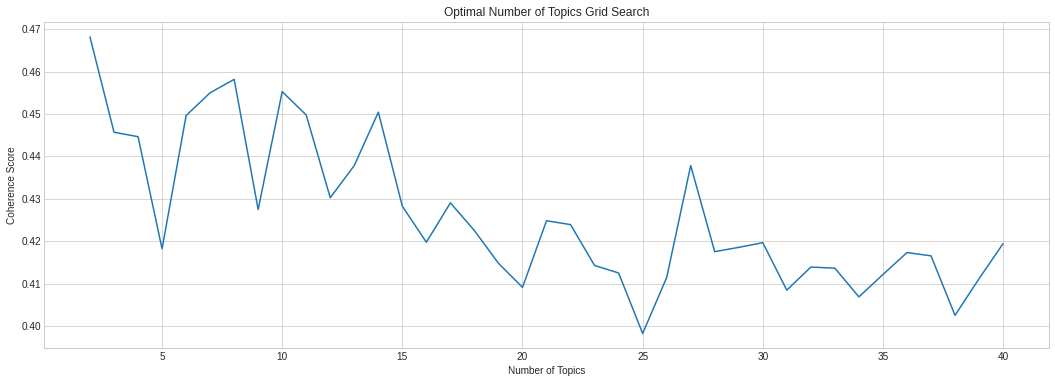

In [ ]:
lda_model.find_best_num_topics()

In [ ]:
num_topic_range = range(2, 11)
alpha_range = list(np.arange(0.0, 1.01, 0.1))
alpha_range.append("symmetric")
alpha_range.append("asymmetric")
beta_range = list(np.arange(0.0, 1.01, 0.1))
beta_range.append("symmetric")

lda_model.tune(num_topic_range=num_topic_range, alpha_range=alpha_range, beta_range=beta_range)

tuning: 100%|██████████| 1404/1404 [35:53<00:00,  1.53s/it, max_coherence_score=0.499, best_params={'num_topics': 2, 'alpha': 'asymmetric', 'beta': 0.0}]


Finished hyperparameter tuning, model updated!


In [ ]:
lda_model.fit(**lda_model.best_params_, predict_training_samples=True)

lda_model.print_output()

Topic: 0	Coherence Score: 0.4381
Words: 0.081*"iphon" + 0.048*"product" + 0.042*"batteri" + 0.041*"camera" + 0.036*"appl" + 0.029*"xr" + 0.026*"life" + 0.025*"buy" + 0.023*"price" + 0.023*"amazon"

########

Topic: 1	Coherence Score: 0.5590
Words: 0.040*"screen" + 0.032*"iphon" + 0.032*"appl" + 0.028*"product" + 0.027*"xr" + 0.027*"batteri" + 0.026*"camera" + 0.025*"amazon" + 0.025*"issu" + 0.023*"2"

########

Perplexity Score: nan 
Overall Coherence Score: 0.4986


In [ ]:
topic_names = [
    "Apple/iPhone's product pricing, battery, camera, and quality", #
    "Amazon's Product? (Unclear)",
    "Battery life, camera, quality, display", #
    "Satisfaction of switching from android to iPhone", #
    "iPhone XR's camera, battery, screen, quality, etc.", #
    "Something about iPhone and/or Amazon (Unclear)", #
    "Comparing iPhone With other phones and/or very detailed reviews" #
]


topics = '''
Topic: 0	Coherence Score: 0.4498
Words: 0.103*"product" + 0.060*"iphon" + 0.037*"appl" + 0.037*"price" + 0.035*"batteri" + 0.031*"camera" + 0.029*"qualiti" + 0.022*"xr" + 0.017*"life" + 0.015*"superb"

########

Topic: 1	Coherence Score: 0.3734
Words: 0.059*"product" + 0.059*"amazon" + 0.052*"love" + 0.049*"buy" + 0.047*"money" + 0.033*"valu" + 0.027*"mobil" + 0.026*"thank" + 0.017*"experi" + 0.016*"iphon"

########

Topic: 2	Coherence Score: 0.5568
Words: 0.121*"batteri" + 0.085*"life" + 0.048*"camera" + 0.028*"work" + 0.025*"face" + 0.022*"qualiti" + 0.020*"iphon" + 0.015*"display" + 0.013*"d" + 0.013*"perform"

########

Topic: 3	Coherence Score: 0.6137
Words: 0.042*"👍" + 0.032*"appl" + 0.023*"iphon" + 0.023*"👌" + 0.021*"android" + 0.019*"io" + 0.018*"user" + 0.018*"like" + 0.015*"batteri" + 0.013*"time"

########

Topic: 4	Coherence Score: 0.5056
Words: 0.055*"camera" + 0.041*"iphon" + 0.036*"qualiti" + 0.031*"xr" + 0.018*"batteri" + 0.017*"screen" + 0.016*"get" + 0.016*"buy" + 0.015*"work" + 0.015*"appl"

########

Topic: 5	Coherence Score: 0.3642
Words: 0.039*"s" + 0.032*"️" + 0.031*"expect" + 0.030*"appl" + 0.028*"iphon" + 0.023*"deliveri" + 0.022*"❤" + 0.021*"time" + 0.018*"amazon" + 0.015*"like"

########

Topic: 6	Coherence Score: 0.7580
Words: 0.048*"iphon" + 0.021*"t" + 0.020*"xr" + 0.016*"face" + 0.014*"3" + 0.014*"appl" + 0.014*"day" + 0.014*"7" + 0.013*"6" + 0.013*"2"
'''

topics = re.findall('(Topic: \d|Words:.*)', topics)

assert len(topics) / 2 == len(topic_names), "Number of given names doesn't match number of topics!"

topics = {k:', '.join(re.findall('"\w+"', topics[i + 1])) for k, i in zip(topic_names, range(0, len(topics), 2))}

for k, v in topics.items():
    print('topic:', k)
    print('words:', v, end='\n*****\n\n')

topic: Apple/iPhone's product pricing, battery, camera, and quality
words: "product", "iphon", "appl", "price", "batteri", "camera", "qualiti", "xr", "life", "superb"
*****

topic: Amazon's Product? (Unclear)
words: "product", "amazon", "love", "buy", "money", "valu", "mobil", "thank", "experi", "iphon"
*****

topic: Battery life, camera, quality, display
words: "batteri", "life", "camera", "work", "face", "qualiti", "iphon", "display", "d", "perform"
*****

topic: Satisfaction of switching from android to iPhone
words: "appl", "iphon", "android", "io", "user", "like", "batteri", "time"
*****

topic: iPhone XR's camera, battery, screen, quality, etc.
words: "camera", "iphon", "qualiti", "xr", "batteri", "screen", "get", "buy", "work", "appl"
*****

topic: Something about iPhone and/or Amazon (Unclear)
words: "s", "expect", "appl", "iphon", "deliveri", "time", "amazon", "like"
*****

topic: Comparing iPhone With other phones and/or very detailed reviews
words: "iphon", "t", "xr", "face"

In [ ]:

lda_model.visualize_topics_

In [ ]:
df['topic_index'] = lda_model.training_samples_prediction_
df['topic_names'] = df['topic_index'].apply(lambda x: topic_names[x])
df.head()

,title,date,location,rating,text,title_clean,text_clean,topic_index,topic_names
0,"Great phone, if you don't care about OLED scre...",2019-04-12,India,5.0,"Great Phone, I am happy with the phone so far....",don t care screen color,thing notic differ xs xr 1 touch don t feel ma...,1,Amazon's Product? (Unclear)
1,Just don’t buy it from amazon totally waste of...,2019-12-09,India,1.0,Your browser does not support HTML5 video. Iph...,buy amazon wast money,browser support html5 video iphon receiv piec ...,1,Amazon's Product? (Unclear)
2,Worth Every Penny,2019-04-04,India,5.0,When compared with XS only visible difference ...,penni,compar xs differ screen keep prefer xs prosava...,1,Amazon's Product? (Unclear)
3,Blindly go for it.,2019-10-03,India,5.0,Your browser does not support HTML5 video. I c...,NaN,browser support html5 video choos iphon xr x r...,1,Amazon's Product? (Unclear)
4,Apple's Perfection at a premium but ....,2019-10-08,India,5.0,Upgraded from 5s to xr after 3 years of 5s use...,appl s perfect premium,upgrad 5s xr 3 year use purchas ₹37999 batteri...,1,Amazon's Product? (Unclear)
